# CellChat

[CellChat Vignette](https://htmlpreview.github.io/?https://github.com/jinworks/CellChat/blob/master/tutorial/CellChat-vignette.html)

In [1]:
suppressPackageStartupMessages({
    library(devtools)
    library(Seurat)
    library(CellChat)
    library(future)
    library(patchwork)
})

options(future.globals.maxSize = 2 * 1024^3)

In [3]:
install_if_not_installed <- function(repo, package_name) {
  if (!(package_name %in% rownames(installed.packages()))) {
    message(paste("Installing", package_name, "from GitHub..."))
    install_github(repo)
  } else {
    message(paste(package_name, "is already installed."))
  }
}

In [4]:
# Install ComplexHeatmap if not already installed
install_if_not_installed("jokergoo/ComplexHeatmap", "ComplexHeatmap")

install_if_not_installed("immunogenomics/presto", "presto")

install_if_not_installed("jinworks/CellChat", "CellChat")

ComplexHeatmap is already installed.



In [166]:
# Source functions
source("R/cleanCellChatNames.R")
source("R/processCellChat .R", local = TRUE)

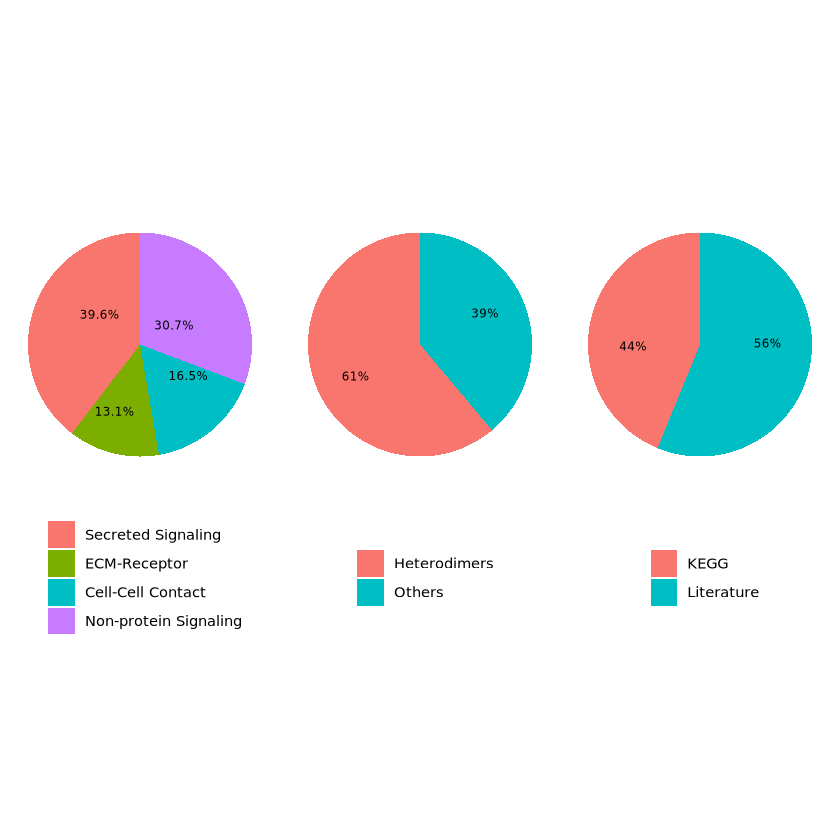

In [54]:
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)

# PD1

In [2]:
# Load AMP II data
obj <- get(load("objects/06.rda"))

In [5]:
# PD1 expressing cells

## Select PD1
pd1_expression <- FetchData(obj, vars = "PDCD1")
# Create new col with PD1 status
pd1_identity <- ifelse(pd1_expression > 0, "PD1+", "PD1-")
# Add new column to object
obj$PD1_identity <- pd1_identity
# Append PD1 expression to cell types
obj@meta.data$PD1_Fine <- paste(obj@meta.data$Fine_Cell_Type, obj@meta.data$PD1_identity, sep = " ")
obj@meta.data$PD1_Broad <- paste(obj@meta.data$Broad_Cell_Type, obj@meta.data$PD1_identity, sep = " ")

In [9]:
seu <- subset(obj, Stim == "LN")
seu <- subset(seu, PD1_Broad == "T Cell PD1-")

In [8]:
seu <- subset(obj, Stim == "LN")
seu <- subset(seu, PD1_Broad == "T Cell PD1+")

An object of class Seurat 
65453 features across 3028 samples within 2 assays 
Active assay: SCT (32333 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [ ]:
Anaptysbio2024

In [ ]:
seu <- subset(obj, Stim == "LN" & PD1_Broad != "PD1+")
seu <- SetIdent(seu, value = "PD1")

# Subset to have similar number of cell compared
test <- subset(x = seu, cells = sampled_cells)
cellchat_ln <- processCellChat(
    obj = test,
    save_path = "objects/cellchat_ln_pd1.rds",
    search = "Cell-Cell Contact")
cellchat_ln

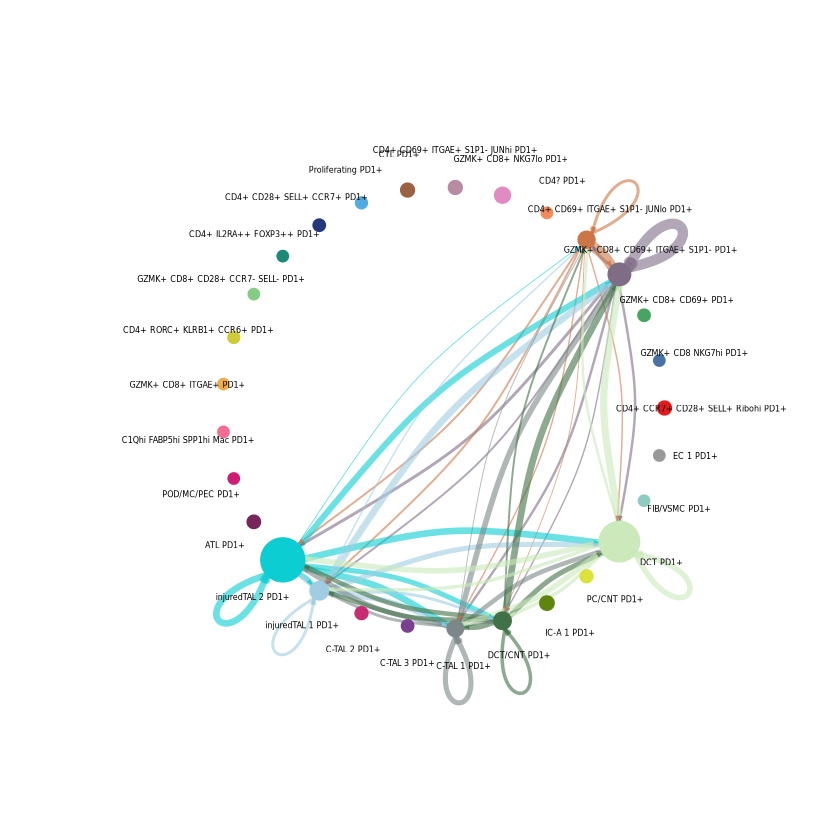

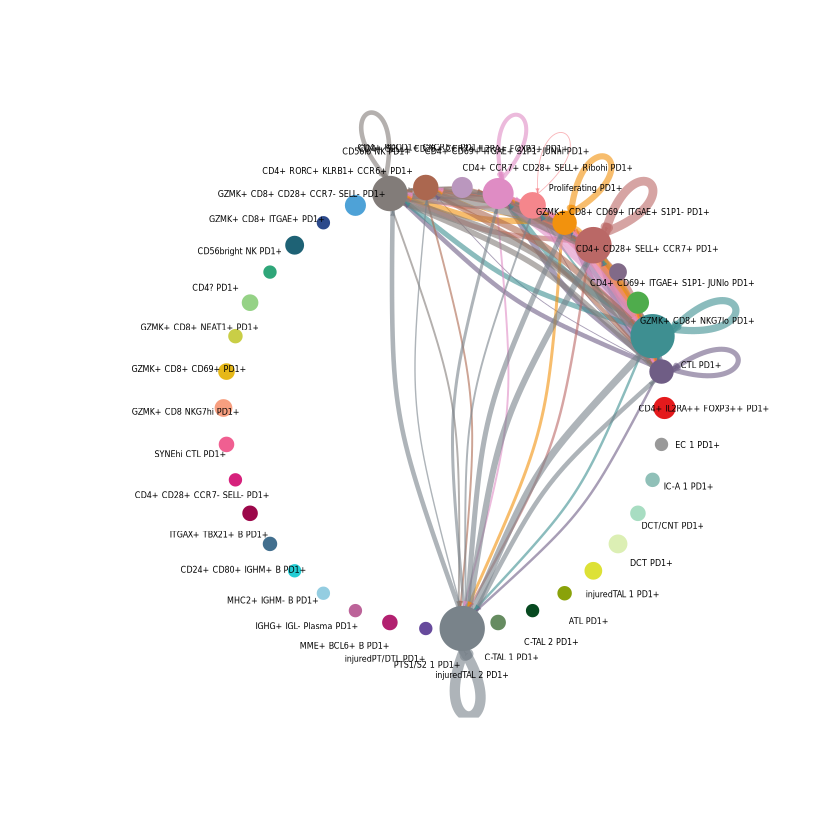

In [165]:
# Plot PD1 cell network

cellchat_control <- cleanCellChatNames(cellchat_control)
groupSize <- as.numeric(table(cellchat_control@idents))

p1 <- netVisual_circle(
    cellchat_control@net$count, 
    vertex.weight = groupSize, 
    weight.scale = TRUE, 
    vertex.label.cex = 0.4, 
    title.name = "Number of interactions")

cellchat_ln <- cleanCellChatNames(cellchat_ln)
groupSize <- as.numeric(table(cellchat_ln@idents))

p2 <- netVisual_circle(
    cellchat_ln@net$count, 
    vertex.weight = groupSize, 
    weight.scale = TRUE, 
    vertex.label.cex = 0.4,
    title.name = "Number of interactions")

# BTLA

In [170]:
rm(obj)
obj <- get(load("objects/06.rda"))

In [196]:
expression <- FetchData(obj, vars = "BTLA")
identity <- ifelse(expression > 0, "BTLA+", "BTLA-")
obj$identity <- identity
obj@meta.data$BTLA <- paste(obj@meta.data$Fine_Cell_Type, obj@meta.data$identity, sep = " ")

In [173]:
# Control 
seu <- subset(obj, Stim == "Control" & identity == "BTLA+")
seu <- SetIdent(seu, value = "BTLA")

cellchat_control <- processCellChat(
    obj = seu,
    save_path = "objects/cellchat_control_btla.rds",
    search = "Cell-Cell Contact")
cellchat_control

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  9. GZMK+ CD8+ CD69+ ITGAE+ S1P1- BTLA+, 15. CD4+ CD69+ ITGAE+ S1P1- JUNlo BTLA+, 2. SYNEhi CTL BTLA+, 16. CD4+ CD28+ SELL+ CCR7+ BTLA+, 18. CD4+ RORC+ KLRB1+ CCR6+ BTLA+, 14. CD4+ CD69+ ITGAE+ S1P1- JUNhi BTLA+, 1. CTL BTLA+, 5. GZMK+ CD8+ NKG7lo BTLA+, 7. GZMK+ CD8+ CD28+ CCR7- SELL- BTLA+, 10. GZMK+ CD8+ ITGAE+ BTLA+, 0.CD56lo NK BTLA+, 19. CD4+ CCR7+ CD28+ SELL+ Ribohi BTLA+, 1. MHC2+ IGHM- B BTLA+, 9. IGHG+ IGL- Plasma BTLA+, 13. CCR7+ LAMP3+ cDC2 BTLA+, 19. cDC1 BTLA+, 17. MHC2hi cDC2 BTLA+, 20. pDC BTLA+, POD/MC/PEC BTLA+, injuredPT/DTL BTLA+, injuredTAL 1 BTLA+, C-TAL 1 BTLA+, injuredTAL 2 BTLA+, C-TAL 3 BTLA+, C-TAL 2 BTLA+, ATL BTLA+, IC-B BTLA+, IC-A 1 BTLA+, IC-A 2 BTLA+, PC/CNT BTLA+, DCT BTLA+, PC BTLA+, EC 1 BTLA+, FIB/VSMC BTLA+ 
The number of highly variable ligand-receptor pairs used for signaling inference is 333 
triMean i

An object of class CellChat created from a single dataset 
 32333 genes.
 122 cells. 
CellChat analysis of single cell RNA-seq data! 

In [174]:
## Define the desired number of cells
desired_number_of_cells <- length(colnames(seu))
seu <- subset(obj, Stim == "LN" & identity == "BTLA+")
seu <- SetIdent(seu, value = "BTLA")
all_cells <- colnames(seu)
set.seed(42) 
sampled_cells <- sample(all_cells, size = desired_number_of_cells, replace = FALSE)

# Subset to have similar number of cell compared
test <- subset(x = seu, cells = sampled_cells)
cellchat_ln <- processCellChat(
    obj = test,
    save_path = "objects/cellchat_ln_btla.rds",
    search = "Cell-Cell Contact")
cellchat_ln

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  19. CD4+ CCR7+ CD28+ SELL+ Ribohi BTLA+, 14. CD4+ CD69+ ITGAE+ S1P1- JUNhi BTLA+, 9. GZMK+ CD8+ CD69+ ITGAE+ S1P1- BTLA+, 16. CD4+ CD28+ SELL+ CCR7+ BTLA+, 1. CTL BTLA+, 15. CD4+ CD69+ ITGAE+ S1P1- JUNlo BTLA+, 5. GZMK+ CD8+ NKG7lo BTLA+, 22. CD4+ PDCD1+ CXCR5+ BTLA+, 21. CD4+ SELL+ CD28+ CCR7+ IL2RA+ FOXP3+ BTLA+, 18. CD4+ RORC+ KLRB1+ CCR6+ BTLA+, 2. SYNEhi CTL BTLA+, 6. GZMK+ CD8 NKG7hi BTLA+, 20. CD4+ IL2RA++ FOXP3++ BTLA+, 4. BCL11A+ TCF4+ IGHE+ B BTLA+, 2. IGHD+ FCER2+ CD22+ B BTLA+, 1. MHC2+ IGHM- B BTLA+, 3. CD24+ CD80+ IGHM+ B BTLA+, 7. IGHG+ IGL- Plasma BTLA+, 10. JCHAIN+ IGA+ IGL+ Plasma BTLA+, 11. IGHG+ IGL+ Plasma BTLA+, 5. ITGAX+ TBX21+ B BTLA+, 8. JCHAIN+ IGA+ IGL- Plasma BTLA+, 19. cDC1 BTLA+, 13. CCR7+ LAMP3+ cDC2 BTLA+, 17. MHC2hi cDC2 BTLA+, 20. pDC BTLA+, C-TAL 1 BTLA+, ATL BTLA+, injuredTAL 1 BTLA+, IC-A 2 BTLA+, EC 1 BT

An object of class CellChat created from a single dataset 
 32333 genes.
 122 cells. 
CellChat analysis of single cell RNA-seq data! 

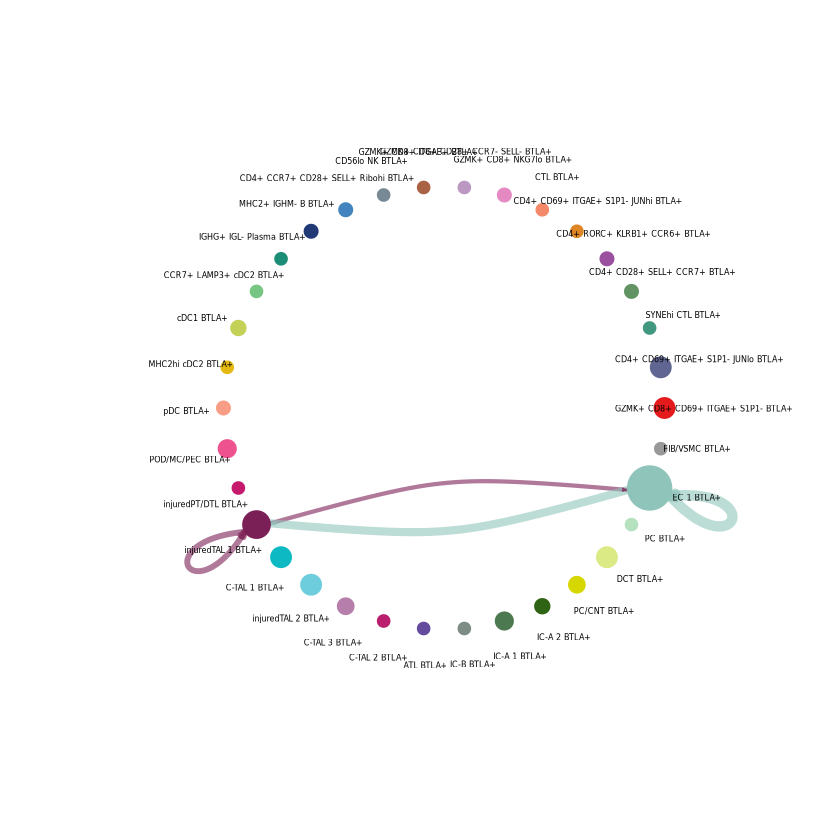

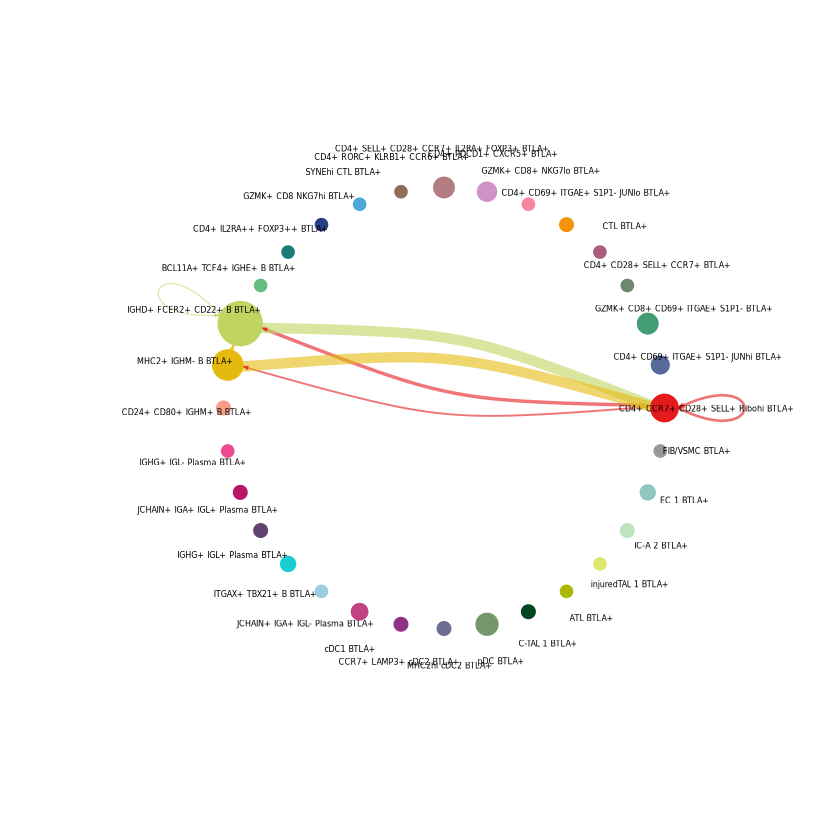

In [175]:
# Plot BTLA cell network

cellchat_control <- cleanCellChatNames(cellchat_control)
groupSize <- as.numeric(table(cellchat_control@idents))

p1 <- netVisual_circle(
    cellchat_control@net$count, 
    vertex.weight = groupSize, 
    weight.scale = TRUE, 
    vertex.label.cex = 0.4, 
    title.name = "Number of interactions")

cellchat_ln <- cleanCellChatNames(cellchat_ln)
groupSize <- as.numeric(table(cellchat_ln@idents))

p2 <- netVisual_circle(
    cellchat_ln@net$count, 
    vertex.weight = groupSize, 
    weight.scale = TRUE, 
    vertex.label.cex = 0.4,
    title.name = "Number of interactions")

# BDCA2 (CLEC4C)

In [176]:
rm(obj)
obj <- get(load("objects/06.rda"))

In [179]:
expression <- FetchData(obj, vars = "CLEC4C")
identity <- ifelse(expression > 0, "BDCA2+", "BDCA2-")
obj$identity <- identity
obj@meta.data$BDCA2 <- paste(obj@meta.data$Fine_Cell_Type, obj@meta.data$identity, sep = " ")

In [195]:
# Control 
seu <- subset(obj, Stim == "Control" & identity == "BDCA2+")
seu <- SetIdent(seu, value = "CLEC4C")

cellchat_control <- processCellChat(
    obj = seu,
    save_path = "objects/cellchat_control_bdca2.rds",
    search = "Cell-Cell Contact")
cellchat_control

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  CLEC4C 


ERROR: Error in wilcoxauc.default(data.use, labels, groups_use = level.use): Must have at least 2 groups defined.


In [ ]:
## Define the desired number of cells
desired_number_of_cells <- length(colnames(seu))
seu <- subset(obj, Stim == "LN" & identity == "BDCA2+")
seu <- SetIdent(seu, value = "CLEC4C")
all_cells <- colnames(seu)
set.seed(42) 
sampled_cells <- sample(all_cells, size = desired_number_of_cells, replace = FALSE)

Subset to have similar number of cell compared
test <- subset(x = seu, cells = sampled_cells)
cellchat_ln <- processCellChat(
    obj = seu,
    save_path = "objects/cellchat_ln_bdca2.rds",
    search = "Cell-Cell Contact")
cellchat_ln

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  CLEC4C 


ERROR: Error in wilcoxauc.default(data.use, labels, groups_use = level.use): Must have at least 2 groups defined.


In [ ]:
# Plot BDCA2 cell network

cellchat_control <- cleanCellChatNames(cellchat_control)
groupSize <- as.numeric(table(cellchat_control@idents))

p1 <- netVisual_circle(
    cellchat_control@net$count, 
    vertex.weight = groupSize, 
    weight.scale = TRUE, 
    vertex.label.cex = 0.4, 
    title.name = "Number of interactions")

cellchat_ln <- cleanCellChatNames(cellchat_ln)
groupSize <- as.numeric(table(cellchat_ln@idents))

p2 <- netVisual_circle(
    cellchat_ln@net$count, 
    vertex.weight = groupSize, 
    weight.scale = TRUE, 
    vertex.label.cex = 0.4,
    title.name = "Number of interactions")